[View in Colaboratory](https://colab.research.google.com/github/mwestt/An-Introduction-to-Bayesian-Inference-in-PyStan/blob/master/PyStan.ipynb)

# Introduction

The many virtues of Bayesian approaches in data science are seldom understated. Unlike the comparatively dusty frequentist tradition that defined statistics in the 20th century, Bayesian approaches match more closely the inference that human brains perform, by combining data-driven likelihoods with prior beliefs about the world. This kind of approach has been fruitfully applied in [reinforcement learning](https://people.eecs.berkeley.edu/~avivt/BRLS_journal.pdf), and efforts to incorporate it into deep learning are a hot area of [current research](https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/). Indeed, it has been argued that Bayesian statistics is the more fundamental of the two statistical schools of thought, and should be the preferred picture of statistics when first introducing students to the subject.

As the predictions from Bayesian inference are probability distributions rather than point estimates, this allows for the quantification of uncertainty in the inferences that are made, which is often missing from the predictions made by machine learning methods.

Although there are clear motivations for incorporating Bayesian approaches into machine learning, there are computational challenges present in their implementation. Often, it is not practical to analytically compute the required distributions, and stochastic sampling methods such as Markov chain Monte Carlo (MCMC) are used instead. One way of implementing MCMC methods in a transparent and efficient way is via the probabilistic programming language, [Stan](https://mc-stan.org). In this article, I'll provide a bit of background about Bayesian inference and MCMC, before demonstrating a simple example where Stan is used to perform inference on a generated dataset, through Stan's Python interface, PyStan.

## Bayes' Theorem

The crux of Bayesian inference is in Bayes' theorem, which was discovered by the Reverend Thomas Bayes in the 18th century. It's based on a fundamental result from probability theory, which you may have seen before:

$$P(A|B) = \frac{P(B|A)P(A)}{ P(B)}$$

That thing on the left is our posterior, which is the distribution we're interested. This theorem can be used to arrive at many counterintuitive results, that are nonetheless true. Take, for instance, the example of [false positives](https://en.wikipedia.org/wiki/Bayes'_theorem#Drug_testing) in drug tests being much higher when the test population is heavily skewed. Rather than go into detail on the basics of Bayesian statistics, I'm going to press onwards to discussing inference with Stan. William Koehrsen has some great material for understanding the intuition behind Bayes' theorem [here](https://towardsdatascience.com/bayes-rule-applied-75965e4482ff).

# Motivating the use of Stan

Bayesian inference is *hard*. The reason for this, according to statistician Don Berry:

*"Bayesian inference is hard in the sense that thinking is hard." -- Don Berry*

Well, OK. What I suppose he means here is that there's little mathematical overhead that gets in the way of making inferences using Bayesian methods, and so the difficulties come from the problems being conceptually difficult rather than any technical or methodological abstraction. But more concretely, Bayesian inference is hard because *solving integrals is hard*. That P(B) up there involves an integral over all possible values that the model parameters can take. Luckily, we're not totally at a loss, as it is possible to construct an approximation to the posterior distribution by drawing samples from it, and creating a histogram of those sampled values to serve as the desired posterior. 

## MCMC Methods

In generating those samples, we need a methodological framework to govern how the sampler should move through the parameter space. A popular choice is Markov chain Monte Carlo. MCMC is a class of methods that combines two powerful concepts: Markov chains and Monte Carlo sampling. Markov chains are stochastic processes that evolve over time in a "memoryless" way, known as the *Markov property*. The Markov property means that the state of a Markov chain transitions to another state with a probability that depends only on the *most recent* state of the system, and not its entire history. Monte Carlo sampling, on other hand, involves solving deterministic problems by repeated random sampling. The canonical way of doing this is with the [Metropolis-Hastings](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) algorithm. Stan instead generates these samples using a state-of-the-art algorithm known as Hamiltonian Monte Carlo (HMC), which builds upon the Metropolis-Hastings algorithm by incorporating many theoretical ideas from physics. Actually, by default it implements a version of HMC called the [No-U-Turn Sampler](https://arxiv.org/pdf/1111.4246.pdf) (NUTS). It's easy to get bogged down in the conceptual complexity of these methods, so don't worry if you're not fully on-board at this stage.

Stan is a probabilistic programming language developed by Andrew Gelman and co, mainly at Columbia University. If you think the name is an odd choice, it's named after Stanislaw Ulam, nuclear physicist and father of Monte Carlo methods. While it is incredibly useful, Stan has a relatively steep learning curve and there isn't exactly a wealth of accessible introductory material on the internet that demonstrates this usefulness. The syntax is itself is mostly borrowed from Java/C, but there are libraries for R, Python, Julia and even MATLAB. Yes, that's right, *even MATLAB*. So whatever your programmatic cup of tea, there's probably something in there for you.

My language of choice is Python, so I'll be using PyStan. Like the rest of Stan, the code for PyStan is open source and can be found here in this [github repository](https://github.com/stan-dev/pystan), and the [documentation](http://mc-stan.org/users/documentation/) is pretty comprehensive. Some of you may be familliar with PyMc or Edward, which I haven't had much experience of. The nice thing about Stan is that you can simply specify the distributions in your model and you're underway, already steaming ahead towards your impending inferential bounty. Where Stan really shines is in very high dimensional problems, where you've got large numbers of predictors to infer. For this article, I am going to and restrict our model to a straightforward univariate linear regression, allowing greater focus on the Stan workflow. The model we'll implement is

$$y \sim \mathcal N\left(\alpha + \beta X, \sigma\right),$$

where we have an intercept $\alpha$ and a gradient $\beta$, and our data $y$ is distributed about this straight line with Gaussian noise of standard deviation $\sigma$.

Stan includes functionality that allows for Bayesian inference with state-of-the-art MCMC methods, approximate Bayesian inference with variational inference (ADVI), and penalized maximum likelihood estimation with optimization (L-BFGS). Here, I'll demonstrate the use of MCMC methods

# Let's build a model

Now we've got some of the background out of the way, let's implement some of what we've discussed. First, you'll need to [install](https://pystan.readthedocs.io/en/latest/windows.html) PyStan, which you can do with:

In [1]:
!pip install pystan

Let's start by importing the relevant packages and setting the numpy seed for reproducibility purposes.

In [0]:
%matplotlib inline
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

Next, we'll begin our Stan script by specifying our model for the linear regression. The model is written in Stan and assigned to a variable of type string called model. This is the only part of the script that needs to by written in Stan, and the inference itself will be done in Python.

A Stan model requires at least three blocks, for each of data, parameters, and the model. The data block specifies the types and dimensions of the data that will be used for sampling, and the parameter block specifies the relevant parameters. The distribution statement goes in the model block, which in our case is a straight line with additional Gaussian noise.

In [0]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Notice that in the parameter block, we've specified the lower bound for sigma as 0, as it's impossible for the magnitude of Gaussian noise to be negative. This is an example of a **prior** on the parameter sigma, and more detailed priors can be added in the model block. Notice that we're not adding any priors to our `alpha` and `beta` parameters, though feel free to experiment with adding priors in the model block and see how they affect the posterior estimates. 

## Data generation

Here we will specify the 'ground truth' values of our parameters which we'll aim to reproduce using Stan, and generate data from these parameters using numpy, making sure to add Gaussian noise. 

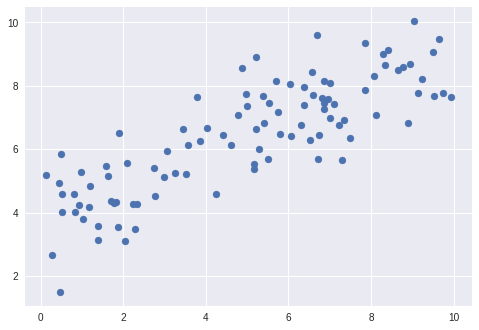

In [4]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)
plt.scatter(x, y)

Now we can perform the inference using our PyStan model. The data needs to be in a Python dictionary to run the sampler, and needs a key for every element we specified in the data block of the Stan model. The model then needs to compile before it can be sampled from, though it is possible to load a pre-compiled model instead. This setup allows us to change the data that we want to generate estimates from, without having to change the model.

## Sampling

Within the sampling method, there are a number of parameters that can be specified. `iter` refers to the total number of samples that will be generated from each Markov chain, and `chains` is the number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. `warmup`, also known as 'burn-in' is the amount of samples that will be discarded from the beginning of each chain, as the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of `iter`, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.

`thin` specifies an interval in sampling at which samples are retained. So if `thin` is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. Finally, `seed` is specified to allow for reproducibility. However, we need initialise

In [5]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2aoso6zq/stanfit4anon_model_cb4cc9c2a04d0e34d711077557307fb7_3763417131017310226.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  6.3e-3   0.19   3.47   3.73   3.85   3.98   4.22    941    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.59    949    1.0
sigma   1.01  2.1e-3   0.07   0.87   0.96    1.0   1.05   1.16   1195    1.0
lp__  -50.62    0.04   1.21 -53.75 -51.14 -50.31 -49.76 -49.26    739   1.01

Samples were drawn using NUTS at Thu Oct 18 05:00:55 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Diagnostics

Once sampling is completed, the fit object can be printed to examine the results of the inference. Here we can see summary statistics for our two regression parameters, as well as for the Gaussian noise in our model. Additionally, we can see those same statistics for a quantity called `lp__`, which according to the Stan manual is the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns, `n_eff` and `Rhat`. `n_eff` is the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of autocorrelation can be mitigated by thinning the Markov chains, as described above. `Rhat` is the [Gelman-Rubin](https://http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain covergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

We can cast this fit output to a pandas DataFrame to make our analysis easier, allowing greater access to the relevant summary statistics. The fit object above has a plot method, but this can be a bit messy and appears to be deprecated. We can instead use the extracted traces to plot our own traces and their corresponding posterior distributions.

In [0]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']
alpha_median, beta_median = df['50%']['alpha'], df['50%']['beta']
alpha_min, alpha_max = df['2.5%']['alpha'], df['97.5%']['alpha']
beta_min, beta_max = df['2.5%']['beta'], df['97.5%']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

## Plotting our regression line

Now that we've extracted the relevant information from our fitted model, we can look at plotting the results of the linear regression.

(-0.358128334169885, 10.43371745657482)

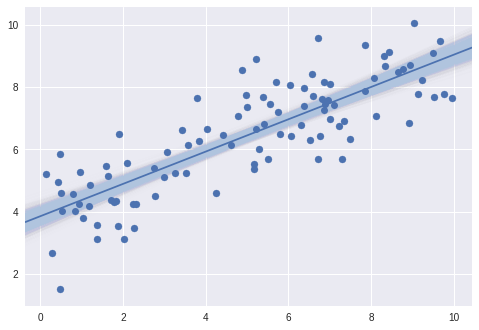

In [7]:
#alpha_mean, beta_mean, sigma_mean = np.mean(alpha), np.mean(beta), np.mean(sigma)
#alpha_median, beta_median, sigma_median = np.median(alpha), np.median(beta), np.median(sigma)
range_x = max(x) - min(x)
x_min = min(x) - 0.05 * range_x
x_max = max(x) + 0.05 * range_x
x_plot = np.linspace(x_min, x_max, 100)

# np.random.seed(34)
# np.random.shuffle(alpha), np.random.shuffle(beta)

for i in range(len(alpha)):
  plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', alpha=0.005 )

plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
#plt.plot(x_plot, alpha_median + beta_median * x_plot)
plt.scatter(x, y)

plt.xlim(x_min, x_max)

## Plotting the posteriors

Rather than restricting our analysis to summary statistics, we can also look in more detail at the series of sampled values for each parameter that we extracted previously, known as a 'trace'. This will allow more insight into the sampling process and is an important part of performing fit diagnostics.

Here I've defined a function that plots the trace and posterior distribution for a given parameter.

In [0]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(np.mean(param), color='r', lw=2, linestyle='--')
  plt.axhline(np.median(param), color='c', lw=2, linestyle='--')

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.axvline(np.mean(param), color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(np.median(param), color='c', lw=2, linestyle='--',label='median')
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.legend()

Now we can call this function for the purposes of plotting our desired parameters.

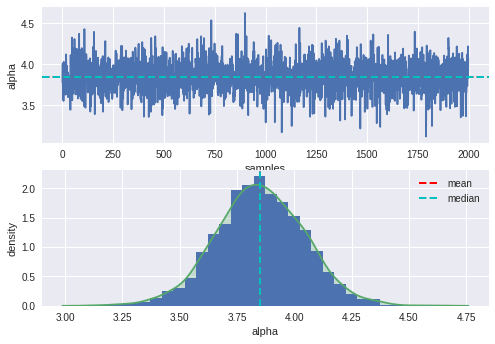

In [9]:
plot_trace(alpha, 'alpha') 

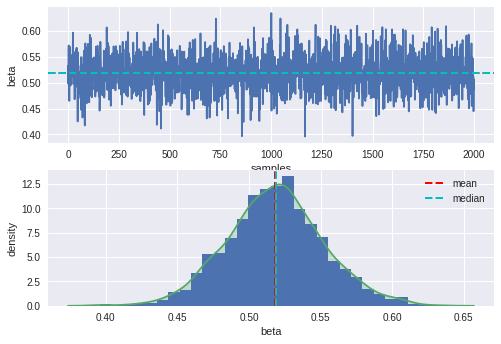

In [13]:
 plot_trace(beta, 'beta')

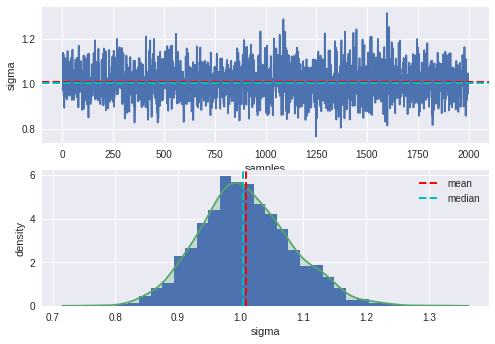

In [11]:
 plot_trace(sigma, 'sigma')

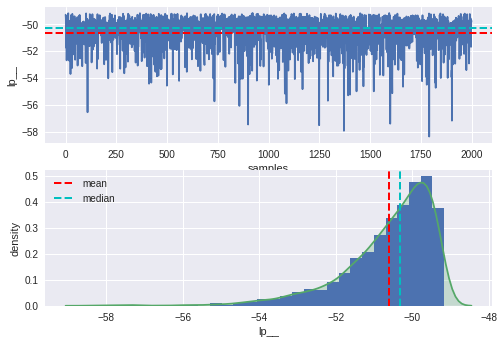

In [12]:
plot_trace(lp, 'lp__')

We can see from the plot of alpha's posterior distribution

In each case, the median and mean are fairly close, though not identical. This shows that although not perfectly Gaussian, our posterior is close enough.

# Conclusions